In [12]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import tensorflow as tf

In [13]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"  {gpu}")

    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
data_path = "/content/combined_dataset-1.xlsx"
df = pd.read_excel(data_path)
df

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,1,2,Female,45,152,63,161,89,97,27.268006,...,1766,1766,1766,1833,1833,1827,1827,1827,1754,1754
1,1,2,Female,45,152,63,161,89,97,27.268006,...,1985,1985,2026,2026,2026,1977,1977,1997,1997,1997
2,1,2,Female,45,152,63,161,89,97,27.268006,...,1942,1900,1900,1938,1938,1938,1924,1924,1929,1929
3,2,3,Female,50,157,50,160,93,76,20.284799,...,2073,2072,2072,2072,2051,2051,2036,2036,2036,2045
4,2,3,Female,50,157,50,160,93,76,20.284799,...,2021,2010,2010,2010,2001,2001,2003,2003,2003,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,218,418,Male,25,173,63,106,69,67,21.049818,...,2702,2671,2679,2675,2695,2703,2667,2662,2687,2635
653,218,418,Male,25,173,63,106,69,67,21.049818,...,2391,2362,2378,2363,2323,2355,2355,2395,2362,2367
654,219,419,Male,24,175,58,108,68,65,18.938776,...,2399,2463,2415,2406,2407,2447,2435,2422,2451,2379
655,219,419,Male,24,175,58,108,68,65,18.938776,...,3075,3091,3067,3051,3121,3135,3091,3103,3146,3151


In [15]:
X_raw = df[[str(i) for i in range(1, 2101)]].dropna()
y_sbp = df.loc[X_raw.index, 'Systolic Blood Pressure(mmHg)']
y_dbp = df.loc[X_raw.index, 'Diastolic Blood Pressure(mmHg)']

In [16]:
def sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride):
    X_win, y_win = [], []
    for i in range(len(X_raw)):
        row = X_raw.iloc[i].values
        for start in range(0, 2100 - window_size + 1, stride):
            end = start + window_size
            X_win.append(row[start:end])
            y_win.append([y_sbp.iloc[i], y_dbp.iloc[i]])
    return np.array(X_win), np.array(y_win)

window_size = 200
stride = 200
X_win, y_win = sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride)

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_win.reshape(-1, window_size)).reshape(X_win.shape)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_win, test_size=0.2
)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5256, 200) (1314, 200) (5256, 2) (1314, 2)


----

In [19]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def residual_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.2):
    residual = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    residual = layers.Activation('relu')(residual)

    residual = layers.Conv1D(filters, kernel_size, padding='same')(residual)
    residual = layers.BatchNormalization()(residual)

    if stride != 1 or x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, strides=stride, padding='same')(x) # for shape
        x = layers.BatchNormalization()(x)

    output = layers.add([x, residual]) # skip conn
    output = layers.Activation('relu')(output)
    output = layers.Dropout(dropout_rate)(output)

    return output

In [20]:
def create_cnn_residual_model(input_shape,
                              dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)

    x = layers.Reshape((input_shape[0], 1))(inputs)

    x = layers.Conv1D(filters=64, kernel_size=7, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = residual_block(x, filters=64, kernel_size=3, dropout_rate=dropout_rate)
    x = residual_block(x, filters=128, kernel_size=3, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, filters=128, kernel_size=3, dropout_rate=dropout_rate)
    x = residual_block(x, filters=256, kernel_size=3, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, filters=256, kernel_size=3, dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu')(x)

    outputs = layers.Dense(2, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [21]:
def train_bp_model(X_train, y_train, X_val, y_val,
                   window_size=200, batch_size=32,
                   epochs=100) :
    model = create_cnn_residual_model(input_shape=(window_size,))

    model.summary()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )

    checkpoint = ModelCheckpoint(
        'best_bp_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    return model, history

In [22]:
model, history = train_bp_model(X_train, y_train, X_test, y_test, window_size=window_size)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 200, 1)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 200, 64)   │        512 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 200, 64)   │     12,352 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 200, 64)   │     12,352 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ activation_7[0][… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 200, 64)   │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 200, 64)   │          0 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 100, 128)  │     24,704 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 100, 128)  │      8,320 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 100, 128)  │     49,280 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 977,986 (3.73 MB)

 Trainable params: 973,762 (3.71 MB)

 Non-trainable params: 4,224 (16.50 KB)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5214.7749 - mae: 57.5807
Epoch 1: val_loss improved from inf to 675.72131, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 5196.5449 - mae: 57.4223 - val_loss: 675.7213 - val_mae: 20.0320 - learning_rate: 5.0000e-04
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 290.9866 - mae: 12.9843
Epoch 2: val_loss improved from 675.72131 to 468.10321, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 291.0181 - mae: 12.9854 - val_loss: 468.1032 - val_mae: 16.1061 - learning_rate: 5.0000e-04
Epoch 3/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 304.7342 - mae: 13.1978
Epoch 3: val_loss improved from 468.10321 to 296.45502, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 304.7143 - mae: 13.1984 - val_loss: 296.4550 - val_mae: 12.7538 - learning_rate: 5.0000e-04
Epoch 4/100
162/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 304.8242 - mae: 13.2390
Epoch 4: val_loss did not improve from 296.45502
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 304.5361 - mae: 13.2338 - val_loss: 308.3960 - val_mae: 13.0036 - learning_rate: 5.0000e-04
Epoch 5/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 285.2087 - mae: 12.8466
Epoch 5: val_loss did not improve from 296.45502
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 285.2824 - mae: 12.8484 - val_loss: 301.9657 - val_mae: 12.7935 - learning_rate: 5.0000e-04
Epoch 6/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 301.2674 - mae: 13.2070
Epoch 6: val_loss improved from 296.45502 to 283.28900, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 301.0419 - mae: 13.2012 - val_loss: 283.2890 - val_mae: 12.4708 - learning_rate: 5.0000e-04
Epoch 7/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 284.5881 - mae: 12.8380
Epoch 7: val_loss improved from 283.28900 to 275.95297, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 284.6683 - mae: 12.8400 - val_loss: 275.9530 - val_mae: 12.6462 - learning_rate: 5.0000e-04
Epoch 8/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 279.0121 - mae: 12.6791
Epoch 8: val_loss did not improve from 275.95297
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 279.1978 - mae: 12.6838 - val_loss: 305.4956 - val_mae: 13.2454 - learning_rate: 5.0000e-04
Epoch 9/100
161/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 295.3092 - mae: 12.9403
Epoch 9: val_loss improved from 275.95297 to 272.11609, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 295.1892 - mae: 12.9384 - val_loss: 272.1161 - val_mae: 12.3533 - learning_rate: 5.0000e-04
Epoch 10/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 290.8016 - mae: 12.9543 
Epoch 10: val_loss did not improve from 272.11609
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 290.7765 - mae: 12.9537 - val_loss: 297.2979 - val_mae: 12.6272 - learning_rate: 5.0000e-04
Epoch 11/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 279.3605 - mae: 12.6883
Epoch 11: val_loss did not improve from 272.11609
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 279.3955 - mae: 12.6892 - val_loss: 281.7023 - val_mae: 12.4895 - learning_rate: 5.0000e-04
Epoch 12/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 281.2979 - mae: 12.6920
Epoch 12: val_loss improved from 272.11609 to 261.71136, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 281.2978 - mae: 12.6921 - val_loss: 261.7114 - val_mae: 12.4700 - learning_rate: 5.0000e-04
Epoch 13/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 294.9215 - mae: 13.0886
Epoch 13: val_loss did not improve from 261.71136
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 294.6727 - mae: 13.0817 - val_loss: 299.9869 - val_mae: 12.6921 - learning_rate: 5.0000e-04
Epoch 14/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 278.6417 - mae: 12.6330
Epoch 14: val_loss did not improve from 261.71136
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 278.7141 - mae: 12.6354 - val_loss: 264.6984 - val_mae: 12.1704 - learning_rate: 5.0000e-04
Epoch 15/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 274.8913 - mae: 12.5910
Epoch 15: val_loss did not improve from 261.71136
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 274.8928 - mae: 12.5907 - val_loss: 266.8110 - val_mae: 12.2417 - learning_rate: 5.0000e-04
Epoch 16/100
162/165 ━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 276.3381 - mae: 12.5314 - val_loss: 253.3626 - val_mae: 11.9817 - learning_rate: 5.0000e-04
Epoch 18/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 273.9442 - mae: 12.5316
Epoch 18: val_loss did not improve from 253.36258
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 273.8768 - mae: 12.5298 - val_loss: 356.9160 - val_mae: 14.1234 - learning_rate: 5.0000e-04
Epoch 19/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 267.8698 - mae: 12.3866
Epoch 19: val_loss did not improve from 253.36258
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 267.8958 - mae: 12.3873 - val_loss: 264.3925 - val_mae: 12.6182 - learning_rate: 5.0000e-04
Epoch 20/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 273.3304 - mae: 12.5197
Epoch 20: val_loss did not improve from 253.36258
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 273.2866 - mae: 12.5187 - val_loss: 256.5974 - val_mae: 12.1230 - learning_rate: 5.0000e-04
Epoch 21/100
163/165 ━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 262.7062 - mae: 12.3977 - val_loss: 247.0778 - val_mae: 11.9415 - learning_rate: 5.0000e-04
Epoch 24/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 274.7724 - mae: 12.6813
Epoch 24: val_loss improved from 247.07782 to 246.98557, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 274.6310 - mae: 12.6759 - val_loss: 246.9856 - val_mae: 11.8761 - learning_rate: 5.0000e-04
Epoch 25/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 268.4325 - mae: 12.4975
Epoch 25: val_loss did not improve from 246.98557
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 268.3663 - mae: 12.4946 - val_loss: 273.8311 - val_mae: 12.2344 - learning_rate: 5.0000e-04
Epoch 26/100
161/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 265.3100 - mae: 12.3141
Epoch 26: val_loss did not improve from 246.98557
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 265.3438 - mae: 12.3150 - val_loss: 248.1674 - val_mae: 11.9500 - learning_rate: 5.0000e-04
Epoch 27/100
162/165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 274.2157 - mae: 12.5238
Epoch 27: val_loss did not improve from 246.98557
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 273.9719 - mae: 12.5188 - val_loss: 280.6294 - val_mae: 12.3150 - learning_rate: 5.0000e-04
Epoch 28/100
163/165 

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 265.9565 - mae: 12.3152 - val_loss: 241.8552 - val_mae: 11.6635 - learning_rate: 2.5000e-04
Epoch 36/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 252.7655 - mae: 12.0424
Epoch 36: val_loss did not improve from 241.85519
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 252.8391 - mae: 12.0436 - val_loss: 252.2383 - val_mae: 12.0636 - learning_rate: 2.5000e-04
Epoch 37/100
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 266.8760 - mae: 12.4918
Epoch 37: val_loss did not improve from 241.85519
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 266.7248 - mae: 12.4872 - val_loss: 247.9524 - val_mae: 11.9041 - learning_rate: 2.5000e-04
Epoch 38/100
162/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 255.3880 - mae: 12.1575
Epoch 38: val_loss did not improve from 241.85519
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 255.3573 - mae: 12.1555 - val_loss: 278.8734 - val_mae: 12.3590 - learning_rate: 2.5000e-04
Epoch 39/100
163/165 ━━━

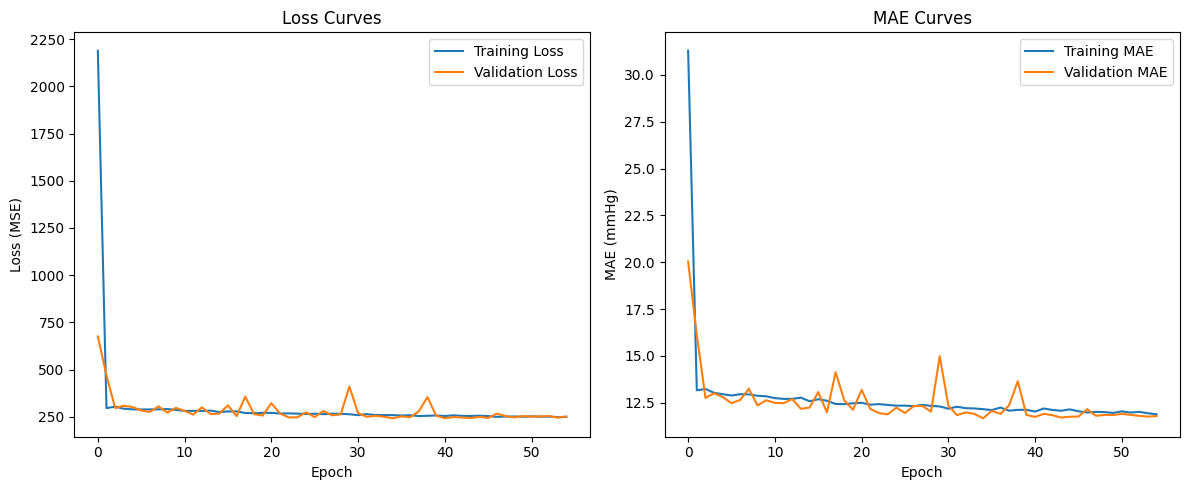

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (mmHg)')
plt.title('MAE Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 227.9552 - mae: 11.5181
Test Loss (MSE): 241.8552
Test MAE: 11.6635


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


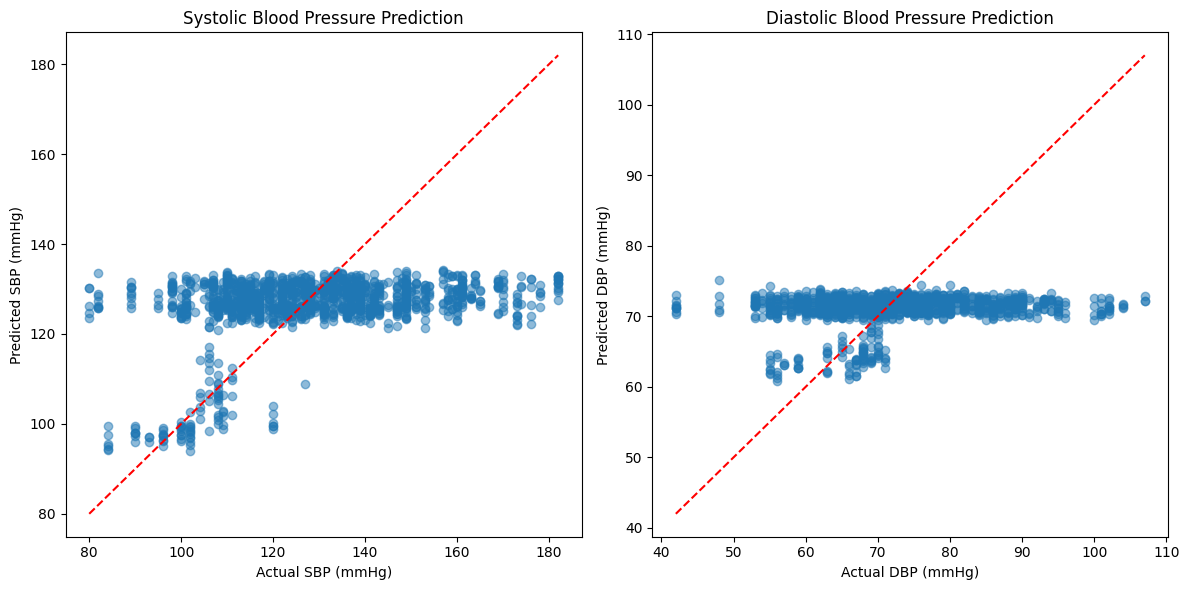

In [26]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()],
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')
plt.xlabel('Actual SBP (mmHg)')
plt.ylabel('Predicted SBP (mmHg)')
plt.title('Systolic Blood Pressure Prediction')

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()],
         [y_test[:, 1].min(), y_test[:, 1].max()], 'r--')
plt.xlabel('Actual DBP (mmHg)')
plt.ylabel('Predicted DBP (mmHg)')
plt.title('Diastolic Blood Pressure Prediction')

plt.tight_layout()
plt.show()